In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import json

In [85]:
# 1. Load the data
data = pd.read_csv('data/SP500.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# round to 2 decimal places
data = data.round(2) 

In [86]:
# 2. Preprocess the data
features = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Verify that data[:, 3] refers to the 'Close' price
assert(data.columns[3] == 'Close')

In [87]:
# 3. Load & extract hyperparameters

# Load hyperparameters
with open('configs/configs.json', 'r') as file:
    hyperparams = json.load(file)

# Extract hyperparameters
seq_length = hyperparams['seq_length']
lstm_units = hyperparams['lstm_units']
dropout_rate = hyperparams['dropout_rate']
dense_units = hyperparams['dense_units']
batch_size = hyperparams['batch_size']
epochs = hyperparams['epochs']
use_early_stop = hyperparams['use_early_stop']
early_stop_patience = hyperparams['early_stop_patience']

In [88]:
# 4. Create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Assuming 'Close' price is the target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [89]:
# 5. Build the LSTM model
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, 6)))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(dropout_rate))
model.add(Dense(dense_units))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [90]:
# 6. Train the model
if use_early_stop:
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stop])
else:
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15


2024-07-04 14:31:24.521124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:31:24.737107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:31:24.916074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:31:25.057182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:31:25.257999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - ETA: 0s - loss: 4.6464e-04

2024-07-04 14:31:33.255720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:31:33.316934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 14:31:33.401529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - 11s 43ms/step - loss: 4.6464e-04 - val_loss: 7.5771e-04
Epoch 2/15
212/212 [==============================] - 8s 37ms/step - loss: 3.0317e-05 - val_loss: 5.5891e-04
Epoch 3/15
212/212 [==============================] - 7s 35ms/step - loss: 2.7161e-05 - val_loss: 9.0551e-04
Epoch 4/15
212/212 [==============================] - 7s 32ms/step - loss: 3.1007e-05 - val_loss: 2.1402e-04
Epoch 5/15
212/212 [==============================] - 7s 31ms/step - loss: 4.0810e-05 - val_loss: 0.0017
Epoch 6/15
212/212 [==============================] - 7s 31ms/step - loss: 2.9032e-05 - val_loss: 2.1288e-04
Epoch 7/15
212/212 [==============================] - 8s 39ms/step - loss: 2.8500e-05 - val_loss: 6.3711e-04
Epoch 8/15
212/212 [==============================] - 7s 35ms/step - loss: 2.4067e-05 - val_loss: 1.1792e-04
Epoch 9/15
212/212 [==============================] - 7s 35ms/step - loss: 2.4206e-05 - val_loss: 2.2445e-04
Epoch 10/15
212/212 [============

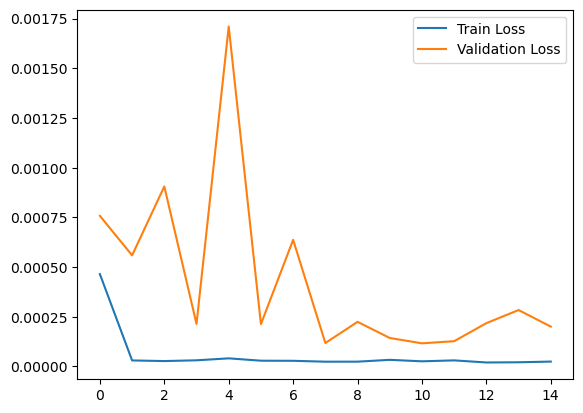

In [91]:
# 7. Evaluate the model 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [99]:
# 8. Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to the original scale
predictions_rescaled = np.zeros_like(scaled_data)
predictions_rescaled[:, 3] = np.nan  # Fill the 'Close' column
predictions_rescaled[split+seq_length:, 3] = predictions[:, -1]
predictions_rescaled = scaler.inverse_transform(predictions_rescaled)

# Extract actual close prices and ensure they're in the right shape for comparison
actual_prices = scaled_data[split+seq_length:, 3]
actual_prices_rescaled = scaler.inverse_transform(np.hstack((np.zeros((len(actual_prices), scaled_data.shape[1] - 1)), actual_prices.reshape(-1, 1))))
actual_prices_rescaled = actual_prices_rescaled[:, -1]

106/106 [==============================] - 2s 14ms/step


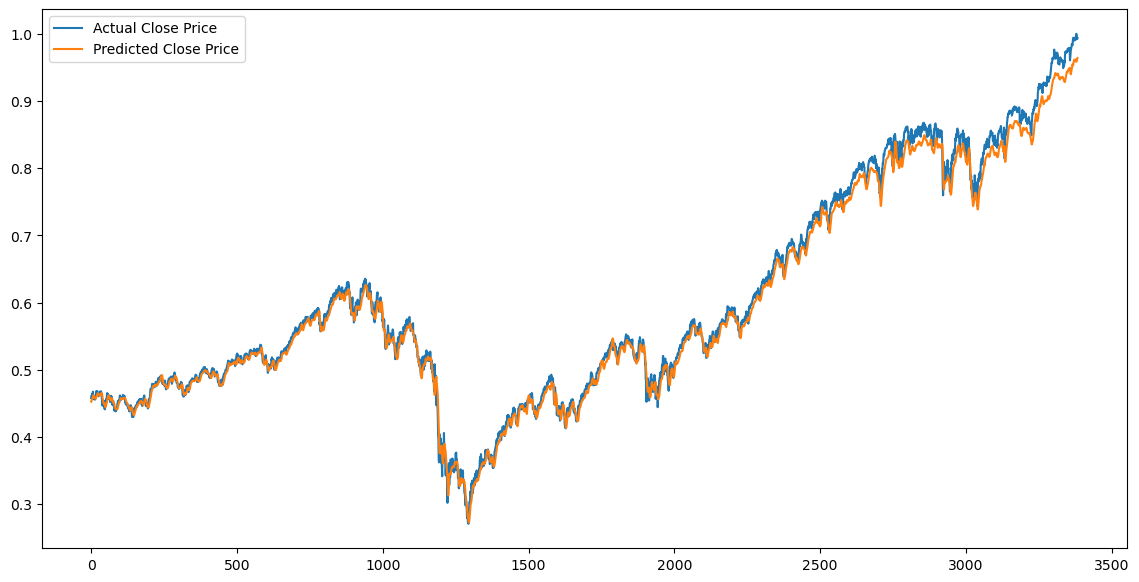

In [100]:
# 9. Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predictions[:, -1], label='Predicted Close Price')
plt.legend()
plt.show()

In [101]:
# 10. Final evaluation of model
# mae = mean_absolute_error(actual_prices, predictions[:, -1])
mse = mean_squared_error(actual_prices, predictions[:, -1])
# rmse = np.sqrt(mse)

# print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
# print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.00020049893212470199
